In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score

import xgboost as xgb
import shap

print('Imports done')

Imports done


In [2]:
df = pd.read_csv("data.csv")
print('Loaded', df.shape)
df.head()

Loaded (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Simple target creation and train/test split


df['readmitted'] = df['readmitted'].astype(str)
df['target_30d'] = df['readmitted'].apply(lambda x: 1 if x.strip() == '<30' else 0)

features = [c for c in df.columns if c not in ['readmitted','target_30d','encounter_id','patient_nbr'] if c in df.columns]

# basic numeric/categorical split
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print('Num cols:', len(num_cols), 'Cat cols:', len(cat_cols))

# For simplicity use IterativeImputer on numeric, SimpleImputer + OneHot on categorical
numeric_features = [c for c in features if c in num_cols]
categorical_features = [c for c in features if c in cat_cols]


numeric_pipeline = Pipeline([
    ('imputer', IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

X = df[features]
y = df['target_30d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

Num cols: 14 Cat cols: 37
Train/Test shapes: (81412, 47) (20354, 47)


Fitting RF...
Fitting XGB...
RandomForest: Brier=0.0951, ROC-AUC=0.6508


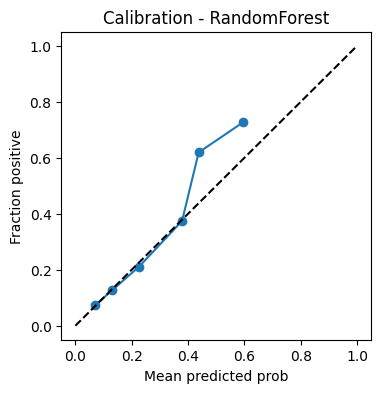

XGBoost: Brier=0.0942, ROC-AUC=0.6770


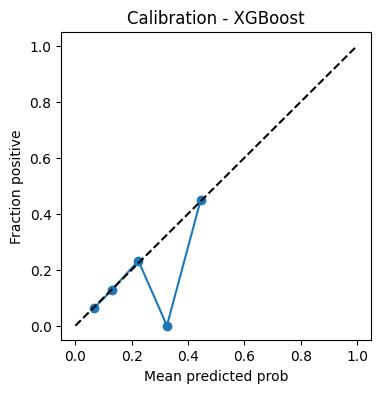

In [4]:
# Train XGBoost and RF pipelines, calibrate and evaluate
rf_pipe = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
xgb_pipe = Pipeline([('preproc', preproc), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))])

print('Fitting RF...')
rf_pipe.fit(X_train, y_train)
print('Fitting XGB...')
xgb_pipe.fit(X_train, y_train)

# Calibration using small holdout from train
X_tr, X_cal, y_tr, y_cal = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)
rf_pipe.fit(X_tr, y_tr)
xgb_pipe.fit(X_tr, y_tr)
rf_cal = CalibratedClassifierCV(rf_pipe, method='isotonic', cv='prefit')
xgb_cal = CalibratedClassifierCV(xgb_pipe, method='isotonic', cv='prefit')
rf_cal.fit(X_cal, y_cal)
xgb_cal.fit(X_cal, y_cal)

# Evaluate
for name, model in [('RandomForest', rf_cal), ('XGBoost', xgb_cal)]:
    y_prob = model.predict_proba(X_test)[:,1]
    brier = brier_score_loss(y_test, y_prob)
    roc = roc_auc_score(y_test, y_prob)
    print(f"{name}: Brier={brier:.4f}, ROC-AUC={roc:.4f}")
    # calibration plot
    frac_pos, mean_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.figure(figsize=(4,4))
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
    plt.plot([0,1],[0,1],'--', color='k')
    plt.title('Calibration - '+name)
    plt.xlabel('Mean predicted prob')
    plt.ylabel('Fraction positive')
    plt.show()



Fitting preprocessing...

=== RandomForest ===
Brier score: 0.0956
ROC-AUC: 0.6580
Accuracy: 0.8884 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Confusion Matrix:
 [[18083     0]
 [ 2271     0]]


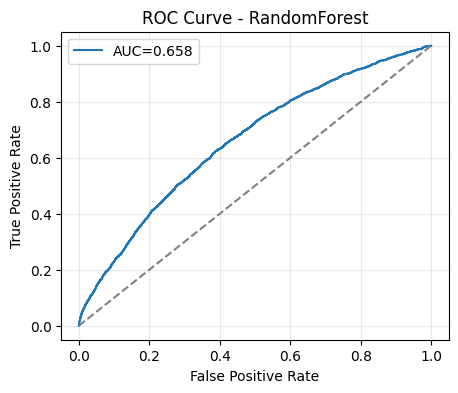

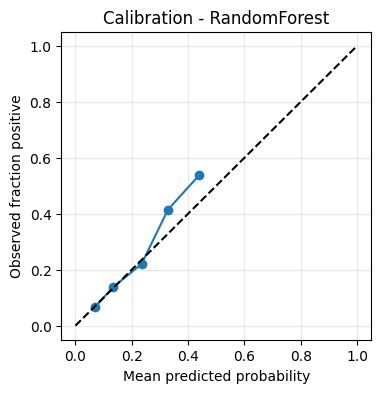


=== XGBoost ===
Brier score: 0.0952
ROC-AUC: 0.6757
Accuracy: 0.8880 | Precision: 0.4651 | Recall: 0.0264 | F1: 0.0500
Confusion Matrix:
 [[18014    69]
 [ 2211    60]]


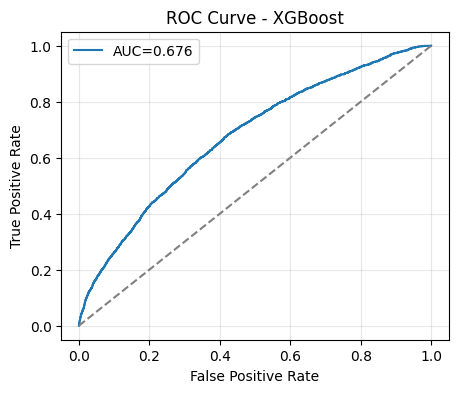

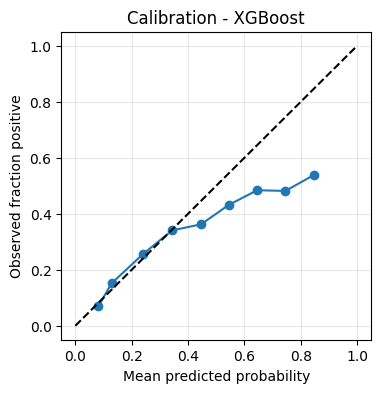


=== LinearSVC ===
Brier score: 0.0963
ROC-AUC: 0.6390
Accuracy: 0.8882 | Precision: 0.4242 | Recall: 0.0062 | F1: 0.0122
Confusion Matrix:
 [[18064    19]
 [ 2257    14]]


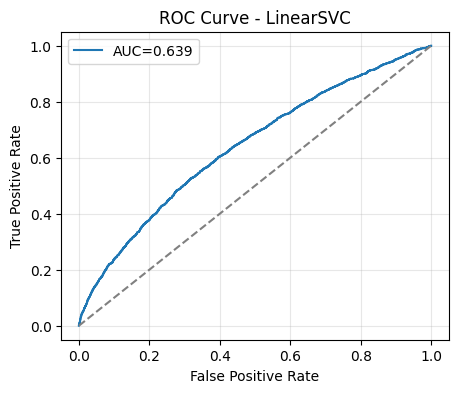

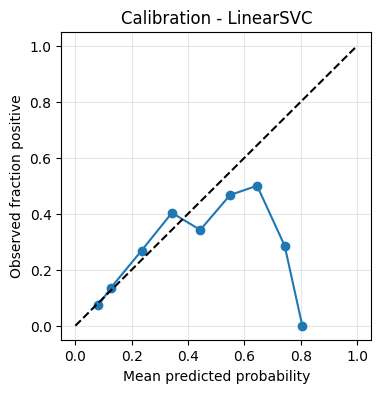

In [5]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, roc_auc_score, roc_curve
)


# --- 1) Preprocess once and transform ---
print("Fitting preprocessing...")
preproc.fit(X_train)
X_train_t = preproc.transform(X_train)
X_test_t  = preproc.transform(X_test)

# --- 2) Split small holdout for calibration (~10% of training data) ---
X_tr_t, X_cal_t, y_tr, y_cal = train_test_split(
    X_train_t, y_train, test_size=0.10, stratify=y_train, random_state=42
)

# --- 3) Define and train models ---
# RandomForest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=12,
                                class_weight='balanced', n_jobs=-1, random_state=42)
rf_clf.fit(X_tr_t, y_tr)
rf_cal = CalibratedClassifierCV(rf_clf, method='sigmoid', cv='prefit')
rf_cal.fit(X_cal_t, y_cal)

# XGBoost
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=6, subsample=0.8,
                            colsample_bytree=0.8, tree_method='hist',
                            use_label_encoder=False, eval_metric='logloss',
                            n_jobs=-1, random_state=42)
xgb_clf.fit(X_tr_t, y_tr)
xgb_cal = CalibratedClassifierCV(xgb_clf, method='sigmoid', cv='prefit')
xgb_cal.fit(X_cal_t, y_cal)

# LinearSVC (fast SVM)
lsvc = LinearSVC(max_iter=20000, dual=False, random_state=42)
lsvc.fit(X_tr_t, y_tr)
svm_cal = CalibratedClassifierCV(lsvc, method='sigmoid', cv='prefit')
svm_cal.fit(X_cal_t, y_cal)

# --- 4) Evaluation function ---
def evaluate_model(name, model, X_test_t, y_test):
    y_prob = model.predict_proba(X_test_t)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # Metrics
    brier = brier_score_loss(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print(f"Brier score: {brier:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Calibration plot
    frac_pos, mean_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.figure(figsize=(4,4))
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
    plt.plot([0,1],[0,1],'--', color='k')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Observed fraction positive')
    plt.title(f'Calibration - {name}')
    plt.grid(alpha=0.3)
    plt.show()

for name, model in [('RandomForest', rf_cal), ('XGBoost', xgb_cal), ('LinearSVC', svm_cal)]:
    evaluate_model(name, model, X_test_t, y_test)

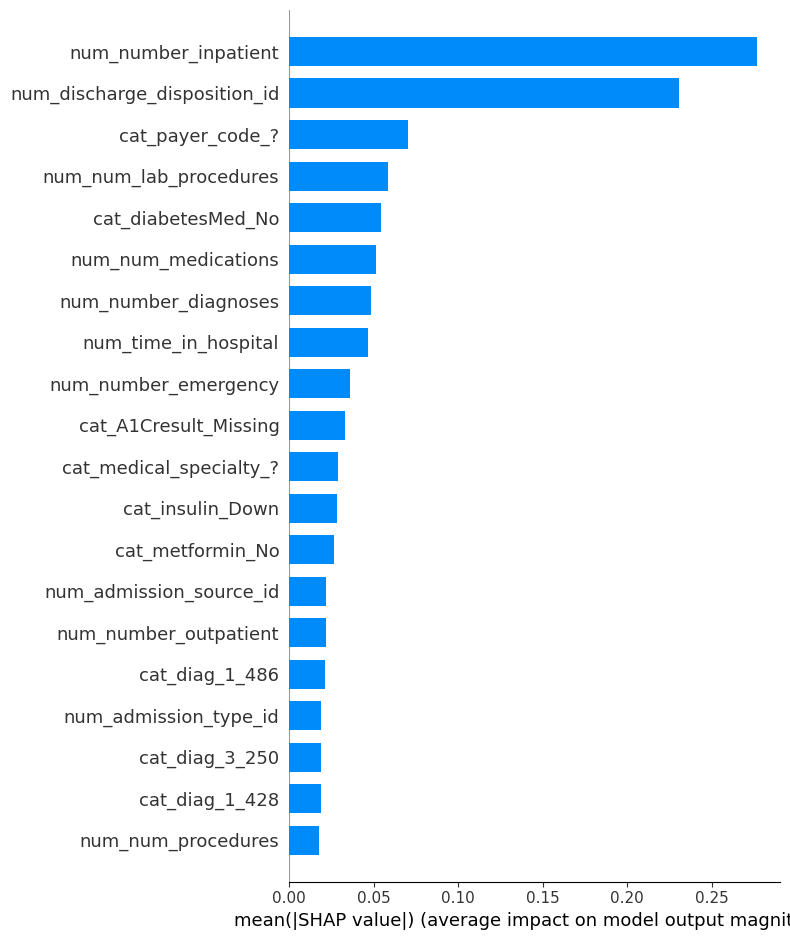

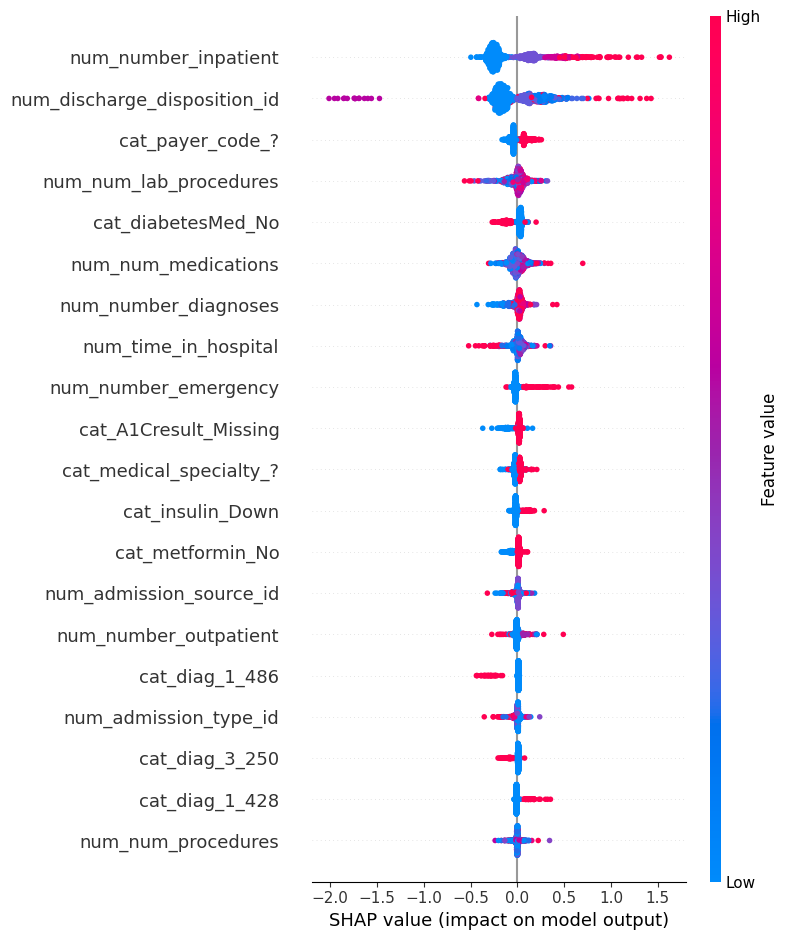

In [6]:
import shap
import pandas as pd
import re

# Subset for SHAP
n_shap = min(1000, X_test_t.shape[0])
X_shap_arr = X_test_t[:n_shap]

# Get raw feature names and clean them
raw_feature_names = preproc.get_feature_names_out()
# Remove or replace forbidden characters: [, ], <, and any non-alphanumeric (except underscore)
clean_feature_names = [
    re.sub(r'[\[\]<]', '_', name)          # Replace [ ] < with underscore
    .replace('__', '_')                    # Avoid double underscores
    .strip('_')                            # Remove leading/trailing underscores
    or f"feature_{i}"                      # Fallback if name becomes empty
    for i, name in enumerate(raw_feature_names)
]

# Ensure all names are valid strings (no duplicates needed, but safe)
clean_feature_names = [str(name) for name in clean_feature_names]

# Create DataFrame with clean names
X_shap_df = pd.DataFrame(X_shap_arr, columns=clean_feature_names)

# SHAP with XGBoost
explainer_xgb = shap.TreeExplainer(xgb_clf)
shap_values_xgb = explainer_xgb.shap_values(X_shap_df)

# Plots
shap.summary_plot(shap_values_xgb, X_shap_df, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_shap_df)  # Beeswarm